In [1]:
import torch

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available. Fastai will use the GPU.")
else:
    device = torch.device("cpu")
    print("GPU is NOT available. Fastai will use the CPU.")

GPU is available. Fastai will use the GPU.


In [3]:
import glob
import os
import json
import time
import datetime

import pandas as pd
import numpy as np
import nibabel as nib

import fastai
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

import scipy.ndimage 
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

from useful_functions import *

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
model_name = f"QSM-T1-NOWEIGHT-{datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')}"
print(model_name)

QSM-T1-NOWEIGHT-20230529-152018


In [5]:
bids_dir = "bids-new"

In [6]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found")

18 sessions found


In [7]:
session_dirs

['bids-new/sub-z0034542/ses-20220715',
 'bids-new/sub-z0186251/ses-20221107',
 'bids-new/sub-z0237546/ses-20230508',
 'bids-new/sub-z0445614/ses-20230510',
 'bids-new/sub-z0705200/ses-20230104',
 'bids-new/sub-z0755228/ses-20211108',
 'bids-new/sub-z1167038/ses-20220315',
 'bids-new/sub-z1181657/ses-20220315',
 'bids-new/sub-z1262112/ses-20220314',
 'bids-new/sub-z1472355/ses-20221222',
 'bids-new/sub-z1568577/ses-20230510',
 'bids-new/sub-z1728751/ses-20220328',
 'bids-new/sub-z1778013/ses-20220715',
 'bids-new/sub-z1818796/ses-20230313',
 'bids-new/sub-z2007565/ses-20220715',
 'bids-new/sub-z2904752/ses-20220826',
 'bids-new/sub-z3171177/ses-20230313',
 'bids-new/sub-z3278008/ses-20211109']

In [8]:
qsm_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs), []))
seg_clean_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "sub*ses*segmentation_clean.*")) for session_dir in session_dirs), []))
t1_resampled_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t1_tra*_resampled.nii*")) for session_dir in session_dirs), []))
t2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs), []))
swi_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*swi.nii*")) for session_dir in session_dirs), []))
mag_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), []))
t1_files = [t1_file.replace("_resampled", "") for t1_file in t1_resampled_files]
seg_files = [seg_clean_file.replace("_clean", "") for seg_clean_file in seg_clean_files]

extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])
ct_files = [extra_file for extra_file in extra_files if any(pattern in extra_file for pattern in ['_na_', '_Pelvis_']) and not any(pattern in extra_file for pattern in ['_t1_tra_', 'ATX', 'AXT', 'ROI', 'resliced', 'segmentation'])]

ct_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_files), [])
ct_resliced_files = sum((glob.glob(ct_file.replace(".nii", "_resliced.nii")) for ct_file in ct_files), [])
ct_resliced_seg_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation_clean.nii")) for ct_file in ct_resliced_files), [])

ct_files = [ct_file for ct_file in ct_files if 'z0237546' not in ct_file]
ct_seg_files = [ct_file for ct_file in ct_seg_files if 'z0237546' not in ct_file]
ct_resliced_files = [ct_file for ct_file in ct_resliced_files if 'z0237546' not in ct_file]
ct_resliced_seg_files = [ct_file for ct_file in ct_resliced_seg_files if 'z0237546' not in ct_file]

print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_files)} CT segmentations found.")
print(f"{len(ct_resliced_files)} resliced CT images found.")
print(f"{len(ct_resliced_seg_files)} resliced CT segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(swi_files)} SWI images found.")
print(f"{len(t1_files)} T1w files found.")
print(f"{len(t1_resampled_files)} resampled T1w files found.")
print(f"{len(seg_files)} GRE segmentations found.")
print(f"{len(seg_clean_files)} cleaned GRE segmentations found.")

17 CT images found.
17 CT segmentations found.
17 resliced CT images found.
17 resliced CT segmentations found.
18 QSM images found.
18 magnitude images found.
18 T2* maps found.
18 SWI images found.
18 T1w files found.
18 resampled T1w files found.
18 GRE segmentations found.
18 cleaned GRE segmentations found.


In [9]:
assert(len(qsm_files) == len(seg_clean_files))
assert(len(qsm_files) == len(t2s_files))
assert(len(qsm_files) == len(swi_files))
assert(len(qsm_files) == len(mag_files))
assert(len(qsm_files) == len(t1_resampled_files))
assert(len(ct_files) == len(ct_seg_files))
assert(len(ct_resliced_files) == len(ct_resliced_seg_files))

# Parameters

In [10]:
df = pd.DataFrame({ 'in_files' : [f"{swi_files[i]}" for i in range(len(swi_files))], 'seg_files' : seg_clean_files })

In [11]:
num_data_channels = 1
random_state = 42
test_size = 3
training_epochs = 700
lr = 0.003
crop_size = [80, 80, 80] # 128, 160, 160

In [12]:
train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

print(f"Training samples shape: {train_df.shape}")
print(f"Testing samples shape: {test_df.shape}")

Training samples shape: (15, 2)
Testing samples shape: (3, 2)


In [13]:
train_df

,in_files,seg_files
5,bids-new/sub-z0755228/ses-20211108/extra_data/swi.nii,bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz
3,bids-new/sub-z0445614/ses-20230510/extra_data/swi.nii,bids-new/sub-z0445614/ses-20230510/extra_data/sub-z0445614_ses-20230510_run-01_segmentation_clean.nii
13,bids-new/sub-z1818796/ses-20230313/extra_data/swi.nii,bids-new/sub-z1818796/ses-20230313/extra_data/sub-z1818796_ses-20230313_run-01_segmentation_clean.nii
16,bids-new/sub-z3171177/ses-20230313/extra_data/swi.nii,bids-new/sub-z3171177/ses-20230313/extra_data/sub-z3171177_ses-20230313_run-01_segmentation_clean.nii
15,bids-new/sub-z2904752/ses-20220826/extra_data/swi.nii,bids-new/sub-z2904752/ses-20220826/extra_data/sub-z2904752_ses-20220826_run-01_segmentation_clean.nii
11,bids-new/sub-z1728751/ses-20220328/extra_data/swi.nii,bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz
2,bids-new/sub-z0237546/ses-20230508/extra_data/swi.nii,bids-new/sub-z0237546/ses-20230508/extra_data/sub-z0237546_ses-20230508_run-01_segmentation_clean.nii
9,bids-new/sub-z1472355/ses-20221222/extra_data/swi.nii,bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii
17,bids-new/sub-z3278008/ses-20211109/extra_data/swi.nii,bids-new/sub-z3278008/ses-20211109/extra_data/sub-z3278008_ses-20211109_run-01_segmentation_clean.nii.gz
4,bids-new/sub-z0705200/ses-20230104/extra_data/swi.nii,bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii


In [14]:
test_df

,in_files,seg_files
0,bids-new/sub-z0034542/ses-20220715/extra_data/swi.nii,bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz
1,bids-new/sub-z0186251/ses-20221107/extra_data/swi.nii,bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
8,bids-new/sub-z1262112/ses-20220314/extra_data/swi.nii,bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz


In [15]:
med_dataset = MedDataset(
    img_list=train_df.seg_files.tolist(),
    dtype=MedMask
)
suggested_voxelsize, requires_resampling = med_dataset.suggestion()
largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)
print(f"Suggested voxel size: {suggested_voxelsize}")
print(f"Requires resampling: {requires_resampling}")
print(f"Largest image size: {largest_imagesize}")

Suggested voxel size: [1.4, 1.4, 1.4]
Requires resampling: False
Largest image size: [146.0, 160.0, 60.0]


# Gold marker segmentation with QSM

In [16]:
def get_center_slices(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    center_slices = [[round(coord) for coord in region.centroid] for region in regions]
    return center_slices

class SetVrange(DisplayedTransform):
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def encodes(self, o:MedImage):
        o[o > self.vmax] = 0
        o[o < self.vmin] = 0
        return o
    
def show_images(x, y, figsize=None, fig_out=None):
    n_samples = x.shape[0]
    n_masks = y.shape[0]
    #assert(n_samples == n_masks)
    n_samples = max(1, n_masks)

    if y.shape[1] > 1:
        mask = torch.argmax(y, dim=1).unsqueeze(1).cpu().numpy()
    else:
        mask = y.cpu().numpy()
    mask = np.array(np.round(mask), dtype=int)
    data = x.cpu().numpy()

    max_sources = 1
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)
        max_sources = max(n_sources, max_sources)
    max_sources = min(7, max_sources)

    img_width = 2
    img_height = 2
    wspace = 0.05
    hspace = 0.05
    n_cols = max_sources
    n_rows = n_samples
    fig_width = img_width * n_cols + wspace * (n_cols - 1)
    fig_height = img_height * n_rows + hspace * (n_rows - 1)

    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(fig_width, fig_height), squeeze=False)
    
    for ax in axes.flat:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    
    for i in range(n_rows):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)

        for j in range(min(n_sources, n_cols)):
            axes[i,j].imshow(data[i][0][:,center_slices[j][1],:], cmap='gray', interpolation='nearest') 
            axes[i,j].imshow(mask[i][0][:,center_slices[j][1],:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(mask[i][0][:,center_slices[j][1],:] != 0, dtype=int) * 0.6, interpolation='nearest')
    plt.tight_layout()
    if fig_out: plt.savefig(fig_out)
    plt.show()
    plt.close()
    
@typedispatch
def show_batch(x:MedImage, y:MedMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    show_images(x, y)

@typedispatch
def show_results(x:MedImage, y:MedMask, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, fig_out='out.png', **kwargs):
    outs = torch.stack([outs[i][0] for i in range(len(outs))], dim=0)
    show_images(x, y, fig_out=f"{fig_out.split('.')[0]}_targ.png")
    show_images(x, outs, fig_out=f"{fig_out.split('.')[0]}_pred.png")
    

In [17]:
import scipy.ndimage

class MarkersIdentified(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn=None, pred=None, targ=None):
        if pred is None or targ is None:
            pred = learn.pred.argmax(dim=1).cpu().numpy()
            targ = learn.y.cpu().numpy()
        
        pred = np.array(np.round(pred) == 1, dtype=int)
        targ = np.array(np.round(targ) == 1, dtype=int)

        pred = scipy.ndimage.binary_dilation(pred)
        targ = scipy.ndimage.binary_dilation(targ)

        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i])
            _, targ_nlabels = scipy.ndimage.label(targ[i])
            
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.overlap_count) / max(1., float(self.targ_marker_count))

class SuperfluousMarkers(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn=None, pred=None, targ=None):
        if pred is None or targ is None:
            pred = learn.pred.argmax(dim=1).cpu().numpy()
            targ = learn.y.cpu().numpy()
        
        pred = np.array(np.round(pred), dtype=int)
        targ = np.array(np.round(targ), dtype=int)

        pred = scipy.ndimage.binary_dilation(pred)
        targ = scipy.ndimage.binary_dilation(targ)

        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i] == 1)
            _, targ_nlabels = scipy.ndimage.label(targ[i] == 1)
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.pred_marker_count - self.overlap_count) / max(1., float(self.pred_marker_count))

In [18]:
dblock = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),#seed=42),
    get_x=ColReader('in_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop(crop_size),
        RandomFlip(axes=("LR",)),
        RandomFlip(axes=("AP",)),
        RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls = DataLoaders.from_dblock(dblock, train_df, bs=4)

learn = Learner(
    dls,
    model=UNet(
        spatial_dims=3,
        in_channels=num_data_channels,  # qsm
        out_channels=3, # background, marker, calcification
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ),
    loss_func=DiceCELoss(
        to_onehot_y=True,
        include_background=True,
        softmax=True,
        ce_weight=torch.Tensor([1, 1, 1])
        #ce_weight=torch.Tensor([0, 0.9998, 0.0002])
    ),
    opt_func=ranger,
    metrics=[multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
)

Training examples: 12
Validation examples: 3


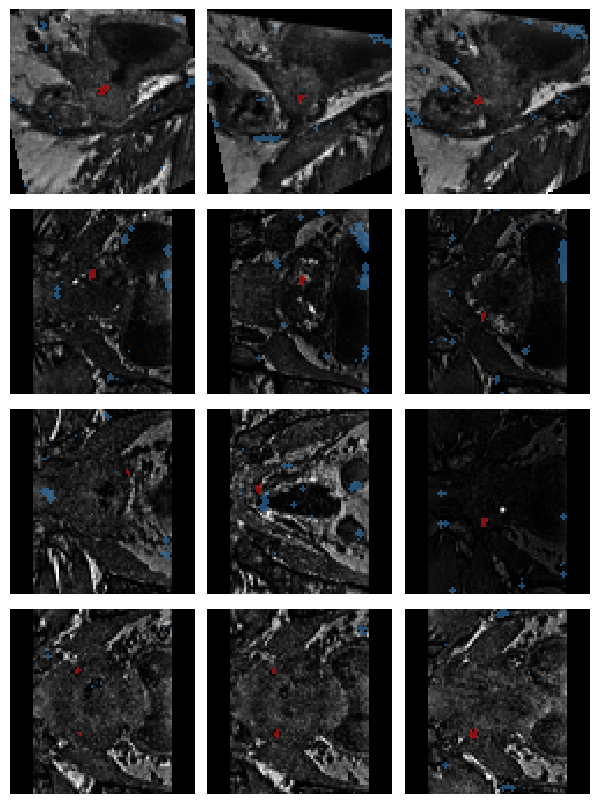

In [19]:
print(f"Training examples: {len(dls.train_ds.items)}")
print(f"Validation examples: {len(dls.valid_ds.items)}")
dls.show_batch(anatomical_plane=2)

In [20]:
learn = learn.load('QSM-T1-NOWEIGHT-20230526-152731-best')
learn.model.cuda()

/home/uqaste15/miniconda3/envs/prostate/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [20]:
save_best_model = SaveModelCallback(monitor='valid_loss', fname=f"{model_name}-best")
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=200)
start_time = time.time()
learn.fit_flat_cos(training_epochs, lr, cbs=[save_best_model, early_stop])
end_time = time.time()
duration_mins = (end_time - start_time) / 60
print(f"Finished training after {round(duration_mins, 2)} mins")
learn.save(f"{model_name}-final")

Better model found at epoch 0 with valid_loss value: 2.141160249710083.
Better model found at epoch 1 with valid_loss value: 2.1359729766845703.
Better model found at epoch 2 with valid_loss value: 2.0349409580230713.
Better model found at epoch 3 with valid_loss value: 2.0138020515441895.
Better model found at epoch 4 with valid_loss value: 1.9125843048095703.
Better model found at epoch 5 with valid_loss value: 1.9015785455703735.
Better model found at epoch 6 with valid_loss value: 1.8075145483016968.
Better model found at epoch 7 with valid_loss value: 1.800839900970459.
Better model found at epoch 8 with valid_loss value: 1.7062301635742188.
Better model found at epoch 9 with valid_loss value: 1.701359748840332.
Better model found at epoch 10 with valid_loss value: 1.6047521829605103.
Better model found at epoch 11 with valid_loss value: 1.6006436347961426.
Better model found at epoch 12 with valid_loss value: 1.4994596242904663.
Better model found at epoch 13 with valid_loss valu

Path('models/QSM-T1-NOWEIGHT-20230529-152018-final.pth')

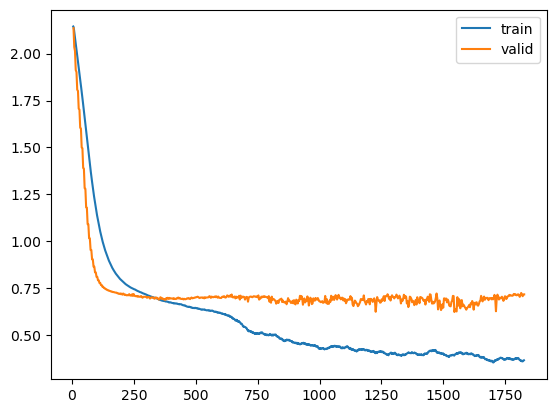

In [21]:
learn.recorder.plot_loss()

In [22]:
# Compute metrics on the entire training dataset
correct_markers = MarkersIdentified()

dblock_train_eval = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=IndexSplitter([]),
    get_x=ColReader('in_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop(crop_size),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)
dls_train_eval = DataLoaders.from_dblock(dblock_train_eval, train_df, bs=1, sampler=SequentialSampler)
for x, y in dls_train_eval.train:
    pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
    correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

print(correct_markers.value)
print(f"Predicted markers: {correct_markers.pred_marker_count}")
print(f"Correct markers: {correct_markers.overlap_count}")
print(f"Incorrect markers: {correct_markers.pred_marker_count - correct_markers.overlap_count}")
print(f"Target markers: {correct_markers.targ_marker_count}")

correct_markers.reset()

dblock_test_eval = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=IndexSplitter([]),
    get_x=ColReader('in_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop(crop_size),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls_test_eval = DataLoaders.from_dblock(dblock_test_eval, test_df, bs=1, sampler=SequentialSampler)
for x, y in dls_test_eval.train:
    pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
    correct_markers.accumulate(pred=pred.cpu(), targ=y.cpu())

print(correct_markers.value)
print(f"Predicted markers: {correct_markers.pred_marker_count}")
print(f"Correct markers: {correct_markers.overlap_count}")
print(f"Incorrect markers: {correct_markers.pred_marker_count - correct_markers.overlap_count}")
print(f"Target markers: {correct_markers.targ_marker_count}")

0.7272727272727273
Predicted markers: 37
Correct markers: 32
Incorrect markers: 5
Target markers: 44
0.7777777777777778
Predicted markers: 18
Correct markers: 7
Incorrect markers: 11
Target markers: 9


In [23]:
loss, *metrics = learn.validate(ds_idx=0, dl=dls_train_eval.train)
print("TRAINING SET METRICS")
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

TRAINING SET METRICS
Dice score: tensor([0.6894, 0.5462]); Markers identified: 0.7272727272727273; Superfluous markers: -0.04033214709371293


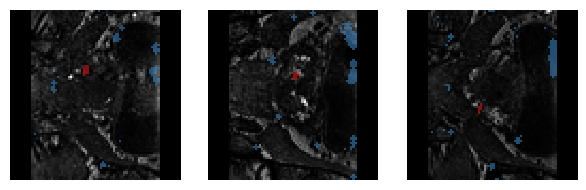

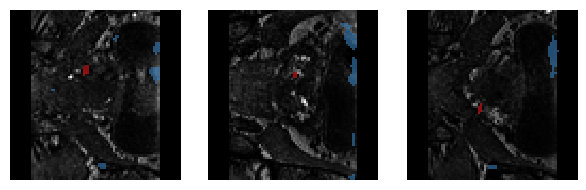

In [24]:
learn.show_results(anatomical_plane=0, dl=dls_train_eval.train, fig_out='seg_results_train.png')

In [25]:
loss, *metrics = learn.validate(ds_idx=0, dl=dls_test_eval.train)
print("TEST SET METRICS")
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

TEST SET METRICS
Dice score: tensor([0.2617, 0.0943]); Markers identified: 0.7777777777777778; Superfluous markers: 0.07203389830508475


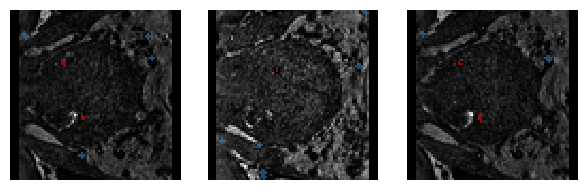

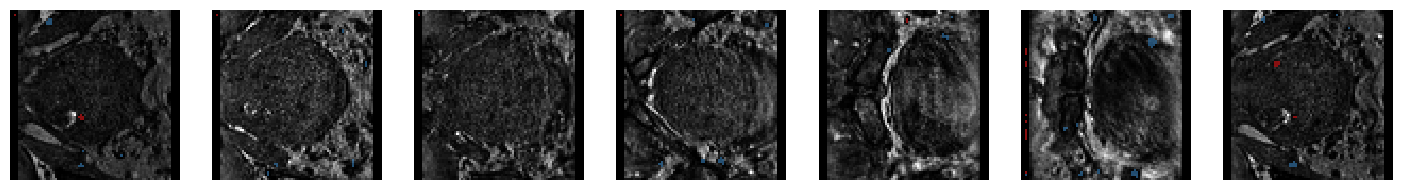

In [26]:
learn.show_results(anatomical_plane=0, dl=dls_test_eval.train, fig_out='seg_results_test.png')

0.639141519678061


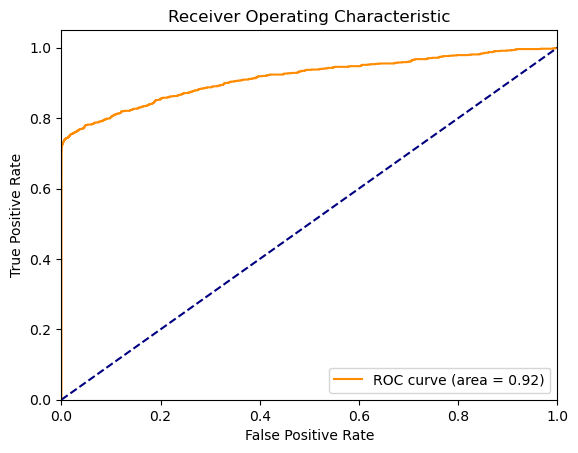

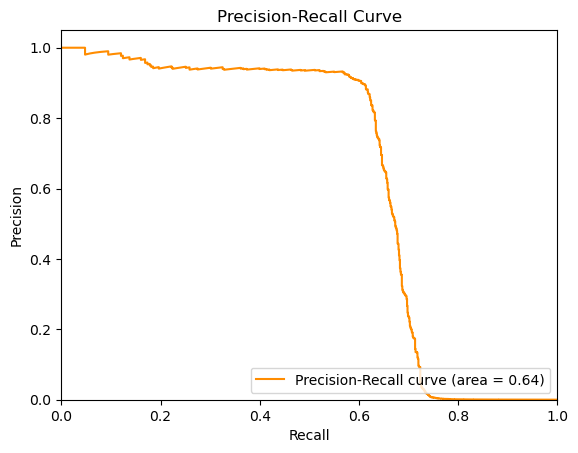

0.2066077307490832


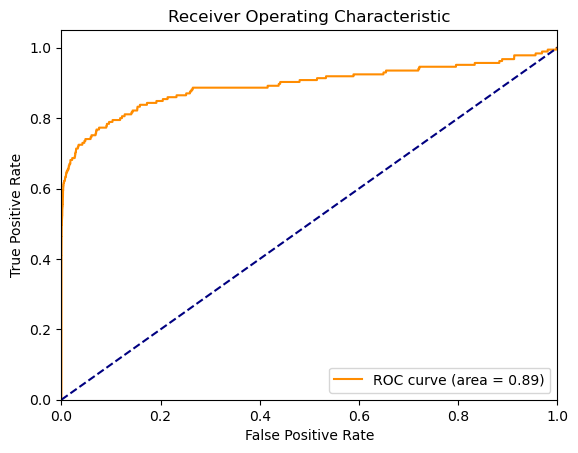

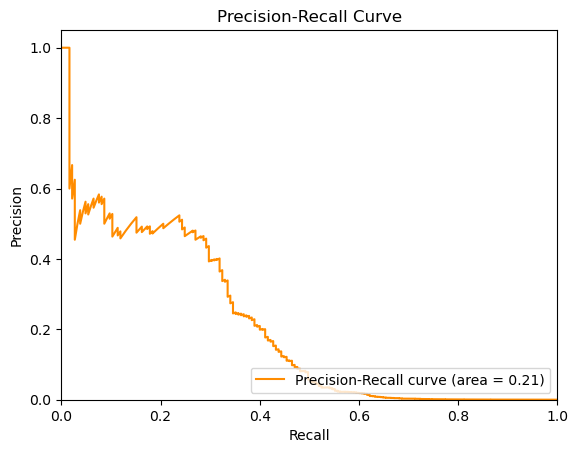

In [27]:
from fastai.vision.all import *
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight

# get predictions
dls_train_eval = DataLoaders.from_dblock(dblock_train_eval, train_df, bs=len(dls_train_eval.train_ds), sampler=SequentialSampler)
dls_test_eval = DataLoaders.from_dblock(dblock_test_eval, test_df, bs=len(dls_test_eval.train_ds), sampler=SequentialSampler)

for x, y in [dls_train_eval.train.one_batch(), dls_test_eval.train.one_batch()]:
    pred = learn.model(x)[:,1,:,:,:].unsqueeze(1).cpu().detach().numpy()
    pred -= np.min(pred)
    pred /= np.max(pred)
    pred = pred.flatten()
    targ = (y.cpu() == 1).to(dtype=torch.int).detach().numpy().flatten()
    sample_weight = compute_sample_weight(class_weight="balanced", y=targ, indices=None)
    fpr, tpr, thresholds = roc_curve(targ, pred, sample_weight=sample_weight)

    # calculate AUC
    roc_auc = auc(fpr, tpr)

    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(targ, pred)
    average_precision = average_precision_score(targ, pred)
    print(average_precision)

    # Plotting ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {round(roc_auc, 2)})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plotting Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, color='darkorange', label=f'Precision-Recall curve (area = {round(average_precision, 2)})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()